In [21]:
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest


In [22]:
class Device:
    def __init__(self, env, name, trust_level, is_authorized, location):
        self.env = env
        self.name = name
        self.trust_level = trust_level
        self.is_authorized = is_authorized
        self.location = location
        self.action = env.process(self.run())
        self.access_denied = 0
        self.false_positive = 0
        self.false_negative = 0
        self.anomalies_detected = 0
        self.activity_log = []

    def run(self):
        while True:
            activity = random.gauss(50, 10)
            self.activity_log.append(activity)
            if not self.verify():
                self.access_denied += 1
                if self.is_authorized:
                    self.false_positive += 1
            else:
                if not self.is_authorized:
                    self.false_negative += 1
                if self.detect_anomaly(activity):
                    self.anomalies_detected += 1
            yield self.env.timeout(random.randint(1, 3))

    def verify(self):
        return self.trust_level >= 50

    def detect_anomaly(self, activity):
        return False  # Placeholder for anomaly detection logic


In [23]:
def calculate_contextual_factor(device):
    location_factor = 0
    time_factor = 0
    activity_factor = 0

    trusted_locations = ['office', 'home']
    location_factor = 5 if device.location in trusted_locations else -5

    current_hour = device.env.now % 24
    time_factor = 2 if 9 <= current_hour <= 17 else -2

    expected_activity_range = (40, 60)
    last_activity = device.activity_log[-1] if device.activity_log else 50
    activity_factor = 3 if expected_activity_range[0] <= last_activity <= expected_activity_range[1] else -3

    contextual_factor = location_factor + time_factor + activity_factor
    return contextual_factor


In [24]:
def dynamic_trust_assessment(device):
    behavioral_factor = -5 if device.detect_anomaly(device.activity_log[-1]) else 5
    historical_factor = 0 if len(device.activity_log) < 10 else (sum(device.activity_log[-10:]) / 10 - 50) / 10
    contextual_factor = calculate_contextual_factor(device)

    new_trust_level = device.trust_level + 0.5 * behavioral_factor + 0.3 * historical_factor + 0.2 * contextual_factor
    device.trust_level = max(0, min(100, new_trust_level))


In [25]:
def run_simulation(env, devices):
    while True:
        for device in devices:
            dynamic_trust_assessment(device)
        yield env.timeout(1)

def simulate(env, devices, simulation_time=100):
    env.process(run_simulation(env, devices))
    env.run(until=simulation_time)
    return devices

env = simpy.Environment()
devices = [
    Device(env, f'{i}', random.randint(30, 70), random.choice([True, False]), random.choice(['office', 'home', 'public'])) 
    for i in range(10)
]
simulated_devices = simulate(env, devices)




In [26]:
def train_anomaly_detector(devices):
    activity_data = []
    for device in devices:
        activity_data.extend(device.activity_log)
    activity_data = np.array(activity_data).reshape(-1, 1)
    model = IsolationForest(contamination=0.1)
    model.fit(activity_data)
    return model

anomaly_detector = train_anomaly_detector(simulated_devices)


In [27]:
def enhanced_detect_anomaly(device, model):
    if not device.activity_log:
        return False
    last_activity = np.array([device.activity_log[-1]]).reshape(1, -1)
    prediction = model.predict(last_activity)
    return prediction == -1  # -1 indicates anomaly

for device in simulated_devices:
    device.detect_anomaly = lambda activity, d=device: enhanced_detect_anomaly(d, anomaly_detector)


In [28]:
data = {
    "Device": [device.name for device in simulated_devices],
    "Access Denied": [device.access_denied for device in simulated_devices],
    "False Positives": [device.false_positive for device in simulated_devices],
    "False Negatives": [device.false_negative for device in simulated_devices],
    "Anomalies Detected": [device.anomalies_detected for device in simulated_devices],
    "Trust Level": [device.trust_level for device in simulated_devices]
}

df = pd.DataFrame(data)
print(df)


  Device  Access Denied  False Positives  False Negatives  Anomalies Detected  \
0      0              1                1                0                   0   
1      1              2                2                0                   0   
2      2              0                0               57                   0   
3      3              2                2                0                   0   
4      4              0                0                0                   0   
5      5              2                0               49                   0   
6      6              1                1                0                   0   
7      7              0                0               52                   0   
8      8              2                0               46                   0   
9      9              3                3                0                   0   

   Trust Level  
0          100  
1          100  
2          100  
3          100  
4          100  
5     

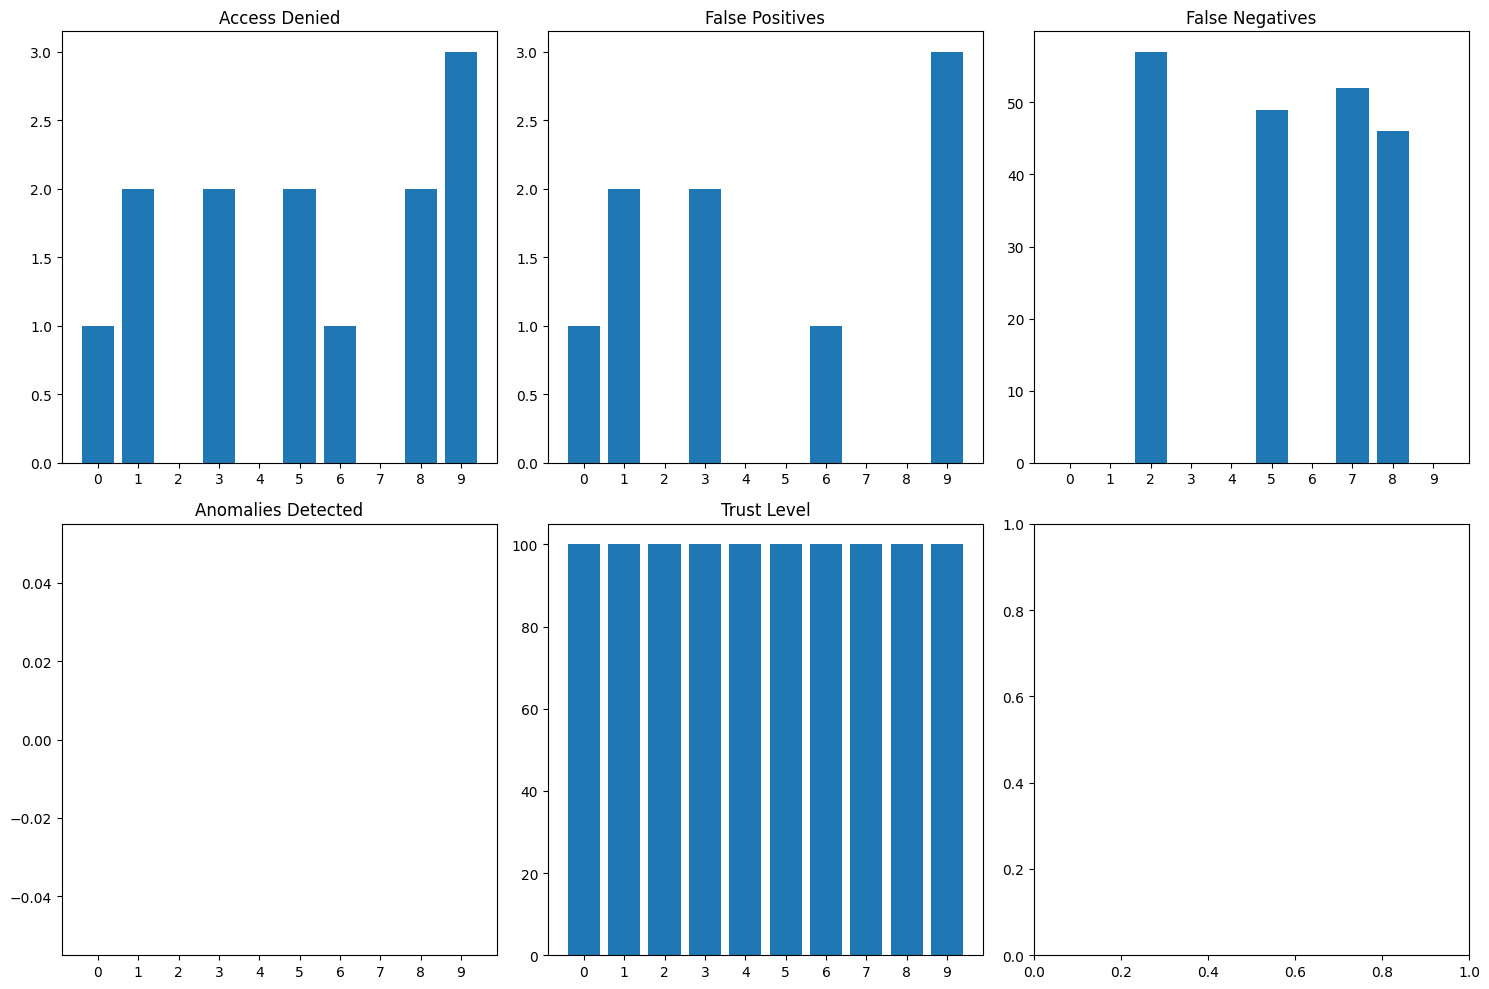

In [29]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs[0, 0].bar(df['Device'], df['Access Denied'])
axs[0, 0].set_title('Access Denied')

axs[0, 1].bar(df['Device'], df['False Positives'])
axs[0, 1].set_title('False Positives')

axs[0, 2].bar(df['Device'], df['False Negatives'])
axs[0, 2].set_title('False Negatives')

axs[1, 0].bar(df['Device'], df['Anomalies Detected'])
axs[1, 0].set_title('Anomalies Detected')

axs[1, 1].bar(df['Device'], df['Trust Level'])
axs[1, 1].set_title('Trust Level')

plt.tight_layout()
plt.show()
